In [102]:
from utils import *
from richutils import *
import warnings 
warnings.filterwarnings("ignore")

from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox
df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))

price = df['Price']
production = df['Production']
withdrawals = df['Withdrawals']
globalPrice = df['GlobalPrice']
exchangeRate = df['ExchangeRate']
temperature = df['TempMax']
precipitation = df['Precipitation']



In [103]:
df

,Index,Price,Production,Withdrawals,GlobalPrice,ExchangeRate,TempMax,TempAvg,Precipitation
Month,,,,,,,,,
2014-09-01,1,51.51,537770.0,1418420,0.1470,44.08,28,27,456.59
2014-10-01,2,51.46,1623075.0,1355836,0.1648,44.80,29,27,436.73
2014-11-01,3,51.28,2277043.0,2156729,0.1588,44.95,29,28,265.32
2014-12-01,4,51.65,2223994.0,1663150,0.1499,44.69,28,27,182.00
2015-01-01,5,51.19,2259613.0,1714490,0.1506,44.60,28,27,82.83
...,...,...,...,...,...,...,...,...,...
2024-04-01,116,85.85,1476667.0,1042072,0.2069,56.95,33,29,22.90
2024-05-01,117,85.54,590428.0,1177536,0.1880,57.76,32,29,130.78
2024-06-01,118,86.73,470766.0,1183388,0.1916,58.70,30,28,330.53


## ARIMAX

<Axes: xlabel='Month'>

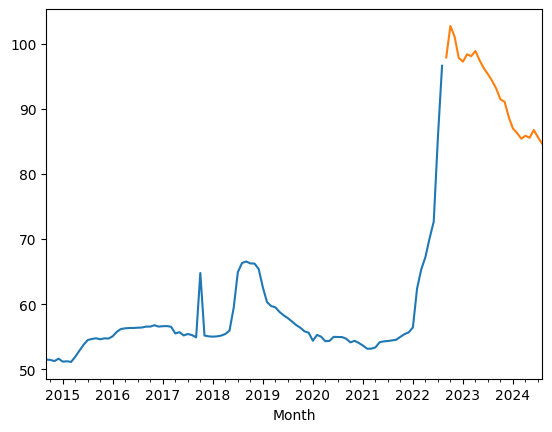

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX as ARIMAX
split = 24
y = price
exog = pd.concat([production, withdrawals, globalPrice, exchangeRate, temperature, precipitation], axis=1)

y_train, y_test = train_test_split(y, split)
exog_train, exog_test = train_test_split(exog, split)

y_train.plot()
y_test.plot()

In [105]:
def ModelX(train, exog_train, test, exog_test, order):
    model = ARIMAX(train, exog=exog_train, order=order).fit()

    start = len(train)
    end = start + len(test) - 1

    pred = model.predict(start=start, end=end, exog=exog_test, typ='levels').rename('Forecast')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', color='blue')
    plt.plot(test.index, test, label='Actual Test Data', color='green')
    plt.plot(test.index, pred, label='Forecasted Test Data', color='red', linestyle='--')
    plt.axvline(x=train.index[-1], color='black', linestyle=':', label='Train-Test Split')
    plt.title('ARIMAX Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, pred


In [106]:
def EvaluateX(train, exog_train, test, exog_test, order):
    model = ARIMAX(train, exog=exog_train, order=order).fit()
    pred = model.predict(start=len(train), end=len(train) + len(test) - 1, exog=exog_test, typ='levels').rename('Forecast')

    mse = ((pred - test) ** 2).mean()
    rmse = mse ** 0.5
    mae = (abs(pred - test)).mean()
    mape = (abs(pred - test) / abs(test)).mean() * 100

    print(f'Evaluation of ARIMAX{order}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'AIC: {model.aic:.2f}')
    print(f'BIC: {model.bic:.2f}')


In [107]:
def ForecastX(df, exog, order, months, future_exog):
    model = ARIMAX(df, exog=exog, order=order).fit()
    forecast = model.forecast(steps=months, exog=future_exog).rename('Forecast')
    return forecast, model


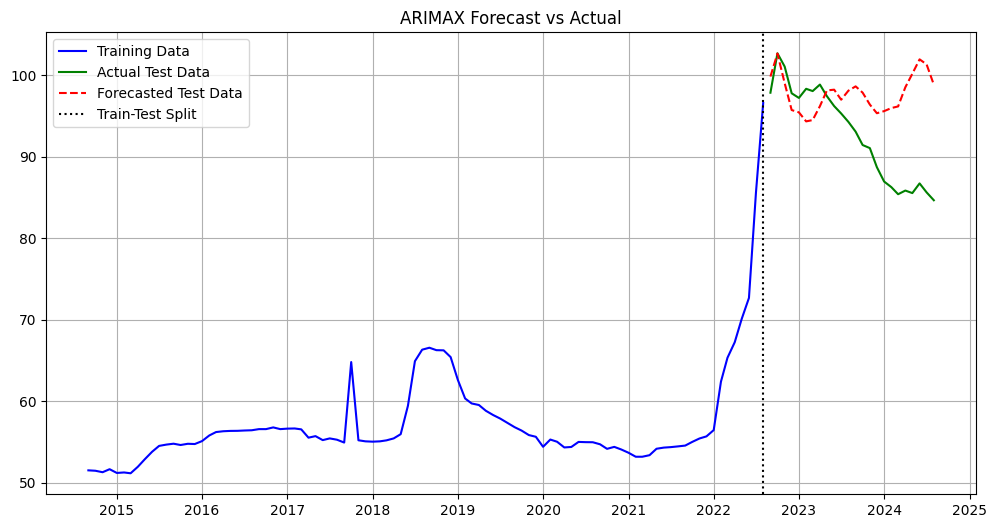

Evaluation of ARIMAX(1, 1, 1)
MSE: 64.9238
MAE: 6.3273
RMSE: 8.0575
MAPE: 7.16%
AIC: 444.51
BIC: 467.50
2024-04-01     98.531016
2024-05-01    100.191105
2024-06-01    101.955539
2024-07-01    101.339733
2024-08-01     98.846551
Freq: MS, Name: Forecast, dtype: float64
Month
2024-04-01    85.85
2024-05-01    85.54
2024-06-01    86.73
2024-07-01    85.63
2024-08-01    84.66
Name: Price, dtype: float64


In [108]:
order = (1, 1, 1 )

model, forecast = ModelX(y_train, exog_train, y_test, exog_test, order)
EvaluateX(y_train, exog_train, y_test, exog_test, order)
print('===============')
print(forecast.tail())
print('===============')
print(price.tail())

### Future and Beyond!

In [109]:
forecast_df = pd.read_csv('exogForecast.csv')
forecast_df.set_index('Month', inplace=True)

future_exog = pd.concat([forecast_df['Production'], forecast_df['Withdrawals'], forecast_df['GlobalPrice'], forecast_df['ExchangeRate'], forecast_df['TempMax'], forecast_df['Precipitation']], axis=1)


In [119]:
forecasty, final_model = ForecastX(y, exog, order, 36, future_exog)

In [111]:
confidence = final_model.get_forecast(steps=36, exog=future_exog).conf_int()


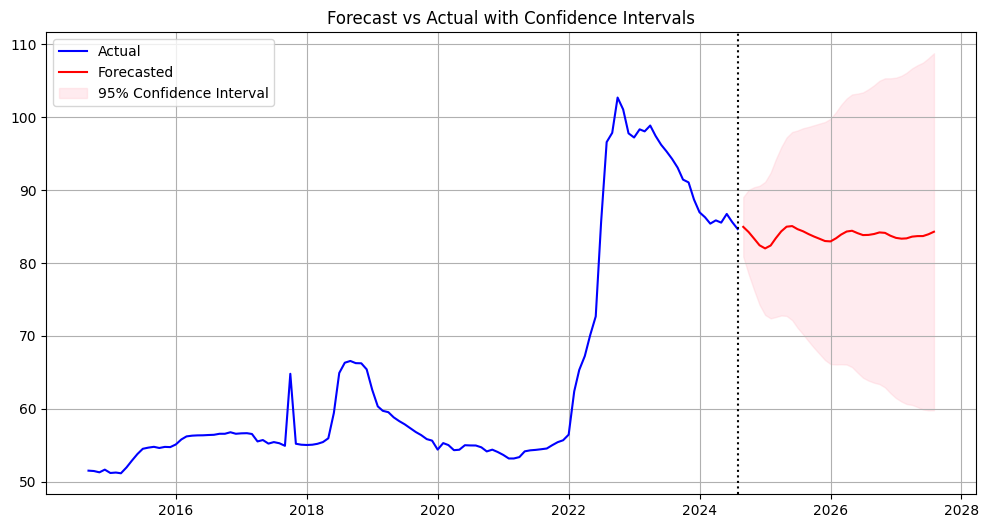

In [120]:
import matplotlib.pyplot as plt

def Forecastedx_plot(actual, forecasted, conf_int=None):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(forecasted, label='Forecasted', color='red')
    plt.axvline(x=actual.index[-1], color='black', linestyle=':')
    
    if conf_int is not None:
        plt.fill_between(forecasted.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

    plt.title('Forecast vs Actual with Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

Forecastedx_plot(price, forecasty, confidence.values)